[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1N2zMUx4KtAkZpoGOmc3l_nmIj82jr3SL?usp=sharing)

# Backpropagation

Backpropagation is the (most popular) method by which artificial neural networks learn: it is how gradient descent is implemented in multi-layer networks. In the simplest of terms, backpropagation is just the Chain Rule from differential calculus.  But saying "it's just the Chain Rule," while conceptually true, can hide some of the intricacy involved in actually coding it up.  In this lesson we walk through implementations of backpropgation from scratch as well as with two major neural network libraries. 

## Video Intro

This [13-minute video by 3blue1brown](https://www.youtube.com/watch?v=Ilg3gGewQ5U) is an execellent introduction to backpropagation. 

The sample problem he shows is handwritten digit classification using images that are made up of 28x28 (=784) pixels. This is the classic "MNIST Dataset" problem that we will consider further below. 



## A Multi-Layer Network

Previously we coded up networks with multiple layers, and here we will return to the "MLP" case of one hidden layer: Between the input $X$ and output $\tilde{Y}$ of the network we encountered earlier, we now interpose a "hidden layer," connected by two sets of weights $w^{(0)}$ and $w^{(1)}$ as shown in the figure below.  This image is a bit more complicated than diagrams one might typically encounter; I wanted to be able to show and label all the different "parts."  We will explain what the various symbols mean as we continue after the figure.
![image of multi-layer network](https://i.imgur.com/WjaQDnW.png)


As before, the combined operation of weighted sum and nonlinear activation is referred to as a(n artificial) neuron; in the diagram above there are 4 "hidden neurons" --- or equivalently  "4 neurons in the hidden layer" --- as well as one neuron for output.  (The activations $f^{(0)}$ and $f^{(1)}$ may be the same, or they may be different.)

## Semantics: What is a Layer?
The term "layer" in regards to neural network is not always used consistently.  You may find it used in different senses by different authors.

1. Some users of the term will only use it with repect to *weight matrices*, (since these are the parts of the network which are adjusted in learning).
2. Others will refer to the input and (predicted) output as layers, and may or may not include the weights as layers..
3. Others will only count  additional  "hidden layers" between the inputs and outputs, and these "layers" are *connected by* multiple weight matrices.  
4. Some will speak of "activation layers."  In software libraries like Keras, many different types of operations and storage are referred to as layers.

For the work we've done so far, we've had inputs and outputs connected by one weight matrix, subject to a nonlinear activation function.  Is this a two-layer network made of input and output "layers,"" or is it a single-layer network, because there is only one weight matrix?  What about the activation layer?  This is to some degree a semantic issue which one does not need to get hung up on.

**For our purposes** it is convenient to refer to the inputs $X$, the 'activated' hidden states $H$, and the output $\tilde{Y}$ as "layers", numbering them 0, 1, and 2 respectively, and using the script notation $\mathcal{L}^l$ to denote each layer, where the layer index $l=0..2$, so that

$$
\mathcal{L}^{(0)} = X, \ \ \ \ \mathcal{L}^{(1)} = H,\ \ \ \ \mathcal{L}^{(2)} = \tilde{Y}
$$

This makes it easy to write the value of higher-numbered layers in terms of lower-numbed layers, i.e.,
$$
\mathcal{L}^{(l+1)} = f^{(l)}\left( {\mathcal{L}^{(l)}}^T \cdot w^{(l)} \right),
$$
where the dot $\cdot$ denotes a matrix product.   This is often referred to as a **"feed foward"** operation because values are fed from left to right in the above diagram, "forward" through the network.  (Backpropagation will involve feeding values from right to left.)

### Response to student question(s): "What *are* (artificial) neurons?"  
"Like, what does this mean in terms of matrices?"

This will serve as a review [an earlier lesson](https://drscotthawley.github.io/blog/2019/01/30/My-First-Neural-Network.html).  Using the above notation, the operations from the input to the hidden layer look like this in matrix form:

![matrix form of first calcs](https://i.imgur.com/hgtEpVH.png)
...where the lines in dark red and cyan are simply to indicate sample calculations which are part of the matrix multiplication.





## Figuring out dimensions of the weights

When we learned about matrix multipliation, we remarked that most of the time in machine learning, "the trick is to get the inner dimensions to match."

Let's say there are $N$ different input data "points" consisting of $M$ values each.  So the input $X$ is an $N\times M$ matrix.  And let the output $\tilde{Y}$ be a $NxP$ matrix (in our example, $P=1$).  If we were just connecting $X$ and $\tilde{Y}$ with no hidden layer, the single weights matrix would be a $M\times P$ matrix:

$$
(\color{blue}N\times \color{red}M)\cdot(\color{red}M\times \color{green}P) = (\color{blue}N\times \color{green}P)
$$
(The nonlinear activation doesn't change the dimensions of the matrices.)

Adding a hidden layer with $Q$ number of neurons means we will still have $N$ different activations for each neuron (i.e. for each datapoint), so that $H$ is a $N\times Q$ matrix. 
Thus the dimensions of $w^0$ must "match" between these two matrices, and so $w^0$ must be a $M\times Q$ matrix:

 $$
(\color{blue}N\times \color{red}M)\cdot(\color{red}M\times \color{purple}Q) = (\color{blue}N\times \color{purple}Q)
$$
Similarly $w^1$ must be a $Q\times P$ matrix, and the full operation in terms of matrix dimensions is

$$
(\color{blue}N\times \color{red}M)\cdot(\color{red}M\times \color{purple}Q)\cdot(\color{purple}Q\times \color{green}P) = (\color{blue}N\times \color{green}P).
$$
Compare this to the diagram above for $P=1$, $Q=4$. 

*Note: If you add bias terms to your model, you may need to remember that the number of columns in both the input $X$ and hidden layer $H$ are greater by one, i.e. $\color{red}{M}\rightarrow \color{red}{M+1}$, etc.*



##..a bit of code

The layers $\mathcal{L}^l$ can be represented in Python a  list called `layers` which has a of length 3.  Similarly, our weights can be items in a list called `weights`.
Returning to [our first sample problem from before](https://github.com/drscotthawley/DLAIE/blob/main/Lessons/5_SampleNN_2_Bias_and_CE.ipynb): Can we find a neural network that will map inputs $X$ to outputs $Y$?

$$X = \left[ {\begin{array}{ccc}
   0 & 0 & 1\\
   0 & 1 & 1\\
   1 & 0 & 1\\
   1 & 1 & 1\\
  \end{array} } 
\right]
  , \ \ \ \  Y = 
 \left[ {\begin{array}{c}
   0   \\
   0  \\
   1  \\
   1 \\
  \end{array} } \right]
$$


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Training data: input and target 
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
Y = np.array([[0,0,1,1]]).T

# define auxiliary variables
N, M, P  = X.shape[0], X.shape[1], Y.shape[1]    # infer matrix shape variables from training data
Y_tilde = np.zeros((N,P))                        # setup storage for network output 

# Hidden layers
Q = 4                     # number of hidden neurons, i.e. "size of hidden layer"
H = np.zeros((N,Q))

# weight matrices
w0 = 2*np.random.random((M,Q)) - 1
w1 = 2*np.random.random((Q,P)) - 1

# Make lists for layers and weights
layers = [X, H, Y_tilde]
weights = [w0, w1]

# Just try a sample feed-forward calculation with random intialization to see how this works 
# Feed-forward (with linear activation):
for l in range(2):
  layers[l+1] = np.dot(layers[l], weights[l])
  print("layers [",l+1,"] =\n", layers[l+1], sep="")  # sep="" just omits spaces

layers [1] =
[[-0.71619863 -0.93579012  0.4707394  -0.27924993]
 [-0.7101555  -0.1050841   0.91379718  0.29545498]
 [-1.16689961 -0.7912951   0.85311015 -0.32876382]
 [-1.16085648  0.03941092  1.29616794  0.24594109]]
layers [2] =
[[ 0.37453611]
 [-0.30449833]
 [-0.07951087]
 [-0.75854532]]


That was not training code, and not even a full feed-forward. 

Generalizing this so it will do the full feed-forward will take a bit more code.
For now, we'll leave a placeholder routine for backpropagation called `update_weights()`; we'll fill it in later. 

In [ ]:
# Activation choices
def sigmoid(x, deriv=False): 
  f = 1/(1+np.exp(-x))
  return f*(1-f) if deriv else f

def relu(x, deriv=False):   
  return 1*(x>0) if deriv else x*(x>0)

# ***** Placeholder: Backprop code will go in here *******
def update_weights(weights, layers, Y, alpha, activ):
  return weights                   # for now, it's a no-op


def fit(layers, Y, activ=[sigmoid]*2, use_bias=True, alpha=1.0, maxiter=10000):
  """
  Routine for training using a multi-layer network
    layers:    list of layer values, i.e. layers =  [X, H, Y_tilde]
    Y:         target output
    activ:     list of activation functions. default = list of 2 sigmoids
    use_bias:  Whether to include a constant offset in weighted sums
    alpha:     learning rate
    maxiter:   number of iterations to run
  """
  lmax = len(layers)-1             # max index of layers, also = # of weights
  
  if use_bias:           # add a column of 1's to every layer except the last
    for el in range(lmax):
        new_col = np.ones((layers[el].shape[0],1)) 
        layers[el] = np.hstack((new_col, layers[el])) 
  
  # Define weights
  np.random.seed(1)                # for reproducibility
  weights = [None]*lmax            # allocate slots in a blank list
  for el in range(lmax):           # "el" because "l" and "1" may look similar
    weights[el] = 2*np.random.random((layers[el].shape[1], layers[el+1].shape[1])) - 1
        
  loss_hist = []                   # start with an empty list
  for iter in range(maxiter):

    # Feed-forward pass
    for el in range(lmax):
      layers[el+1] = activ[el](np.dot(layers[el], weights[el]))
      
    # Loss monitoring
    diff = layers[lmax] - Y
    loss_hist.append( (diff**2).mean()  )    # use MSE loss for monitoring
          
    # ***** Placeholder: Backprop code will go in here *******
    weights = update_weights(weights, layers, Y, alpha, activ)

  return weights, layers[lmax], loss_hist        


# Test this just to make sure it runs
layers = [X,H,Y_tilde]
weights, Y_tilde, loss_hist = fit(layers, Y, maxiter=1)
for el in range(len(weights)):
  print("weights[",el,"] = \n",weights[el], sep="")

weights[0] = 
[[-0.16595599  0.44064899 -0.99977125 -0.39533485 -0.70648822]
 [-0.81532281 -0.62747958 -0.30887855 -0.20646505  0.07763347]
 [-0.16161097  0.370439   -0.5910955   0.75623487 -0.94522481]
 [ 0.34093502 -0.1653904   0.11737966 -0.71922612 -0.60379702]]
weights[1] = 
[[ 0.60148914]
 [ 0.93652315]
 [-0.37315164]
 [ 0.38464523]
 [ 0.7527783 ]]


...Now that we've achieved feed-foward operation of the network, in order to make it 'learn' or 'train', we need to compare the network's output value $\tilde{Y}$ (which is the same as `layers[2]` by the way) to the target value $Y$, then compute the gradients of the loss function, and then backpropagate in order to update all the weights!



## Backpropagating: Theory
Let's review how we got the gradients for $w^{(1)}$ in [an earlier lesson](https://github.com/drscotthawley/DLAIE/blob/main/Lessons/05_SampleNN_2_Bias_and_CE.ipynb).
In that lesson, defined a loss function $L(\tilde{Y},Y)$ where $\tilde{Y}$ stood for the activations of the very last layer, i.e., in our notation from earlier in this notebook, $\tilde{Y} = \mathcal{L}^{(2)}.$

Each layer consists of weighted sums followed by some activation function.  Denoting the sums by "$S$", e.g. $S^l = \mathcal{L}^l\cdot w^l$, we can find the gradient of $L$ with respect to $w^{(1)}$ by using the Chain Rule, in which we take the product of all the (partial) derivatives "between" the loss function and the weights:
$$
{\partial L\over\partial w^{(1)}} = 
\color{blue}
{\partial L \over\partial \mathcal{L}^{(2)}}
\color{green}
{\partial \mathcal{L}^{(2)} \over\partial S^{(1)}}
\color{red}
{\partial S^{(1)} \over\partial w^{(1)}}
$$
We'll define the first partial derivative to be $\delta^{(2)}$, which works out (given our choice of $L$ from Part 2) to be
$$\color{blue}{
{\partial L \over\partial \mathcal{L}^{(2)}}
=\delta^{(2)} = \tilde{Y}-Y},$$
i.e., it is the error in the final ouput.

The next partial derivative (in $\color{green} {\rm green}$) is just the derivative of the activation function $f$.

The last partial derivative is just $\color{red}{\mathcal{L}^{(1)}}$, so as we saw in the previous lesson, we can write this 'schematically' (i.e. not quite as a properly-set-up matix equation yet) as
$$ 
{\partial L\over\partial w^{(1)}} =
\color{blue}{\delta^{(2)}}
 \color{green} {f^{(1)\prime} }
\color{red}{\mathcal{L}^{(1)}} 
$$
whereas in proper form it will take on this ordering as a matrix equation:
$$
\boxed{
{\partial L\over\partial w^{(1)}} = 
{\mathcal{L}^{(1)}}^T \cdot 
{\delta^{(2)}}
{f^{(1)\prime}}
}.
$$


To get the gradients for $w^{(0)}$, we can make use of a similar "$\delta$" notation if we're careful in how we define a new $\delta^{(1)}$.  Let's write out the chain rule, and put parentheses around a particular group of terms for later:

$$
{\partial L\over\partial w^{(0)}} = 
\color{blue}{
\left(
{\partial L \over\partial \mathcal{L}^{(2)}}
{\partial \mathcal{L}^{(2)} \over\partial S^{(1)}}
{\partial S^{(1)} \over\partial \mathcal{L}^{(1)}}
\right)}
\color{green}
{\partial \mathcal{L}^{(1)} \over\partial S^{(0)}}
\color{red}
{\partial S^{(0)} \over\partial w^{(0)}}
$$
In a manner similar to what we did above, this can be written as
$$
{\partial L\over\partial w^{(0)}} =
\color{blue}{
\left(\delta^{(2)}f^{(1)\prime}w^{(1)}\right)}
\color{green}{f^{(0)\prime}}
\color{red}{\mathcal{L^{(0)}}}
$$ 
We now *define* the terms in parentheses as $\delta^{(1)}$

$$
\color{blue}{
\delta^{(1)} =  \delta^{(2)}f^{(1)\prime}w^{(1)}
},
$$
...which is *kind of* like "the error in the hidden layer," or like the  final solution error projected backward into the hidden layers via our (momentarily fixed) weights $w^{(1)}$.

Then our gradients for $w^{(0)}$ take on a similar form as the gradients for $w^{(1)}$. 'Schematically' this looks like 
$$
{\partial L\over\partial w^{(0)}} =
\color{blue}{\delta^{(1)}}
\color{green}{f^{(0)\prime}}
\color{red}{\mathcal{L^{(0)}}}
$$
and in proper matrix form this is
$$
\boxed{
{\partial L\over\partial w^{(0)}} =
{\mathcal{L}^{(0)}}^T \cdot 
{\delta^{(1)}}
{f^{(0)\prime}}
},
$$
i.e., the *same form* as the preceding layer, just "back" one layer. We are backpropagating the errors $\delta^{(l)}$ from one layer to another in order to update the weights. 

The weights are then updated as before, except now we will write this 'generically' for all weights and layers using the index $l$:
$$
\boxed{
w^{(l)} := w^{(l)} - \alpha {\mathcal{L}^{(l)}}^T \cdot 
{\delta^{(l+1)}}
{f^{(l)\prime}}
},
$$
where
$$
\delta^{(l+1)} = \left\{ \begin{array}{l} 
\tilde{Y}-Y,\ \ \  &\ &l+1=l_{max} \ \ \ \ ({\rm e.g.} \ l_{max}=2)\\
\delta^{(l+2)}f^{(l+1)\prime}\cdot {w^{(l+1)}}^T, &\ &l+1 < l_{max}
\end{array}\right.
$$

The two above equations in boxes comprise the key results for this backpropagation algorithm. Now we need to convert them into code. 


## Writing the Backprop Code
Now we'll use the above analysis to replace the `update_weights()` function from earlier. `update_weights()`  will be where the backpropagation is performed. 

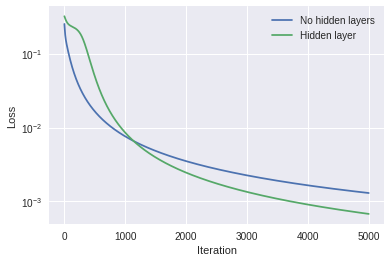

In [ ]:
def update_weights(weights, layers, Y, alpha, activ):
  """
  Backprop routine, for arbitrary numbers of layers, assuming weights & 
  activations are defined
  
  Inputs:
    weights: list of arrays of weights between each layer
    layers:  list of arrays of layer values (post-activation function)
    Y:       target output
    alpha:   learning rate
    activ:   list of activation functions for each (non-input) layer
  Outputs:
    weights (updated)
  """
  lmax = len(layers) - 1                        # a useful variable
  assert len(weights)==lmax                     # make sure number of weights match up
  assert len(activ) >= lmax                     # make sure we defined enough activations for the layers
    
  delta = layers[lmax] - Y                      # error between output and target
  
  for el in range(lmax-1, -1, -1):              # Count backwards to layer zero
    fprime = activ[el](np.dot(layers[el], weights[el]), deriv=True)   # deriv of activation
    weights[el] -= alpha * np.dot( layers[el].T, delta*fprime )       # gradient descent step
    delta = np.dot(delta*fprime, weights[el].T) if (el>0) else None   # setup delta for next pass in loop

  return weights           

# Let's run it!
layers = [X, H, Y_tilde]
alpha = 0.1
maxiter=5000
weights, Y_tilde, loss_hist_2weights = fit(layers, Y, alpha=alpha, maxiter=maxiter)

# compare against a 1-weight (no hidden layer) network:
layers = [X, Y_tilde]
weights, Y_tilde, loss_hist_1weight = fit(layers, Y, alpha=alpha, maxiter=maxiter)

# Plot the loss history
plt.semilogy(loss_hist_1weight, label="No hidden layers")
plt.semilogy(loss_hist_2weights, label="Hidden layer")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Text(0, 0.5, 'Loss')

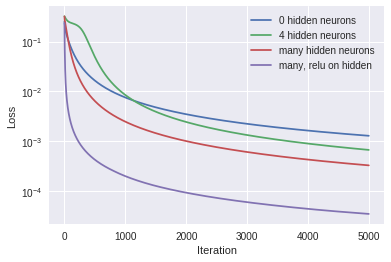

In [ ]:
# Let's add more hidden neurons
Q = 50                     # number of hidden neurons, i.e. "size of hidden layer"
H = np.zeros((N,Q))

layers = [X, H, Y_tilde]
weights, Y_tilde, loss_hist_many = fit(layers, Y, alpha=alpha, maxiter=maxiter)

# try a relu activation for the hidden layer (leave output activ as sigmoid!)
weights, Y_tilde, lhm_relu = fit(layers, Y, alpha=alpha, activ=[relu,sigmoid], maxiter=maxiter)

plt.semilogy(loss_hist_1weight, label="0 hidden neurons")
plt.semilogy(loss_hist_2weights, label="4 hidden neurons")
plt.semilogy(loss_hist_many, label="many hidden neurons")
plt.semilogy(lhm_relu, label="many, relu on hidden")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")

## Another sample problem: Solving XOR
One famous result in the history of neural networks is that a single neuron can't model an exclusive or (XOR) function, but that multiple neurons can. Let's try that:

$$ \overbrace{
 \left[ {\begin{array}{cc}
    0 & 0 \\
    0 & 1 \\
    1 & 0 \\
    1 & 1 \\
  \end{array} } \right]
}^{X} \rightarrow
\overbrace{
 \left[ {\begin{array}{c}
   0   \\
   1  \\
   1  \\
   0 \\
  \end{array} } \right]
  }^Y.
$$
With our multi-layer network, we can solve this.  Note that while (it can be shown that) an exact solution to the XOR problem exists using only 2 hidden neurons and linear activations, a program can still have a hard time *finding* a good approximation via gradient descent, and we use 20 hidden neurons to assist, as follows:

Prediction Y_tilde = [[0.00480128 0.9962425  0.9963109  0.00374649]]
Target Y (correct answer)  = [[0 1 1 0]]


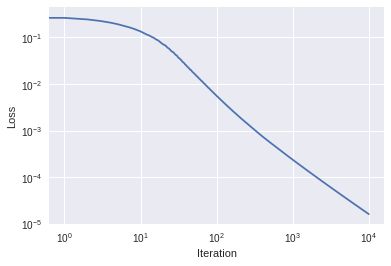

In [ ]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0,1,1,0]]).T
Y_tilde = 0*Y                         # Just allocate some storage
H = np.zeros((N,20))                  

weights, Y_tilde, loss_hist_xor = fit([X,H,Y_tilde], Y, activ=[relu,sigmoid], alpha=0.5)
print("Prediction Y_tilde =",Y_tilde.T)
print("Target Y (correct answer)  =",Y.T)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.loglog(loss_hist_xor)
#print("weights = ",weights)

# Same thing using neural network libraries Keras & PyTorch.
Since most of the time we won't be writing neural 

1.   List item
2.   List item

network systems "from scratch, by hand" in numpy, let's take a look at similar operations using libraries such as Keras or PyTorch. 

## Keras version
[Keras](https://keras.io/) is so simple to set up, it's easy to get started. This is what the previous example for XOR looks like "in Keras":

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

# training data
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0,1,1,0]]).T

# specify model
n_hidden = 20
model = Sequential([
    Dense(n_hidden, input_shape=(X.shape[1],), activation='relu'),
    Dense(1, activation='sigmoid')])

# choices for loss and optimization method
opt = Adam(lr=alpha)   # We'll talk about optimizer choices later
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['binary_accuracy'])

# training iterations
model.fit(X, Y, epochs=maxiter, batch_size=1, verbose=0)

print("\nY_tilde = \n", model.predict(X) )


Y_tilde = 
 [[0.00]
 [1.00]
 [1.00]
 [0.00]]


Keras can get a better appoximation than we did because of the choice of optimizer algorithm. We'll talk about optimization algorithms (refinements to gradient descent) another time. 

## PyTorch version
Unlike Keras, [PyTorch](https://pytorch.org/) does not have any "training wheels."  You have to specify a number of the operations yourself.  It's helpful to have a template to start from, such as the following example for our XOR problem.


Y_tilde = 
 [[2.9910339e-07]
 [9.9999976e-01]
 [9.9999964e-01]
 [3.4460226e-07]]


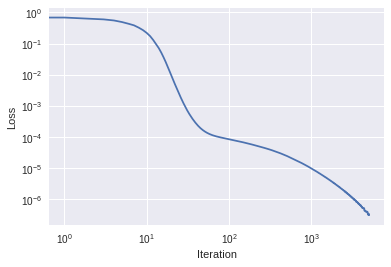

In [ ]:
import torch                  # it's 'PyTorch' but the package is 'torch'
device = torch.device('cpu')  # we don't need gpu yet; this is handy for changing to 'cuda' in GPU runtimes later!

torch.manual_seed(1)  # for reproducibility

# training data
X = np.array([[0,0],[0,1],[1,0],[1,1]],dtype=np.float32)
Y = np.array([[0,1,1,0]],dtype=np.float32).T

# re-cast data as PyTorch variables, on the device (CPU or GPU) were calc's are performed
x, y = torch.tensor(X).to(device), torch.tensor(Y).to(device)   

# specify model (similar to Keras but not quite)
n_hidden = 20                           # number of hidden neurons
model = torch.nn.Sequential(
          torch.nn.Linear(X.shape[1], n_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(n_hidden, 1),
          torch.nn.Sigmoid()
        ).to(device)

# choices for loss and optimization method
loss_fn = torch.nn.BCELoss()      # binary cross-entropy loss
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=alpha)

# training iterations
loss_hist_pytorch = []
for iter in range(maxiter):
  optimizer.zero_grad()                  # set gradients=0 before calculating more
  y_tilde = model(x)                     # feed-forward step
  loss = loss_fn(y_tilde, y)             # compute the loss
  loss_hist_pytorch.append(loss.item())  # save loss for plotting later
  loss.backward()                        # compute gradients via backprop
  optimizer.step()                       # actually update the weights

# print and plot our results
print("\nY_tilde = \n", y_tilde.cpu().data.numpy() )
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.loglog(loss_hist_pytorch)

-----
## Pausing here Nov 1, 2020. More later

----

# Exercise: MNIST


Now that you've built up some experience with reading digits, let's move to handwritten digits!  This is a problem usually solved with an architecture called a Convolutional Neural Network, but our ordinary feed-forward network can do it too. 

The [MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/) is a classic dataset that every ML student works on.  It consists of a large number images of handwritten digits only 28x28 pixels in size.  We will "flatten" these into a row of 784 columns, and output a $\tilde{Y}$ of one-hot-encoded vectore just like we did for the output of the 7-segment display (same digits, 0 to 9!). 



Prediction Y_tilde =
 [[0.01 0.99 0.99 0.01]]
Target Y (correct answer)  =
 [[0.00 1.00 1.00 0.00]]


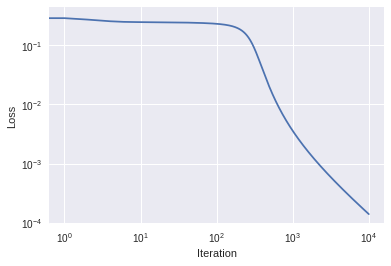

In [ ]:
## TEMPLATE CODE. Scroll down to "MAKE YOUR CHANGES BELOW", below
import numpy as np
import matplotlib.pyplot as plt

### LEAVE THIS UNCHANGED
# First, let's repeat the sigmoid(), relu(), update_weights() and fit() routines
# already defined, so we have a'standalone' code and can easily make changes

# Activation choices
def sigmoid(x, deriv=False): 
  f = 1/(1+np.exp(-x))
  return f*(1-f) if deriv else f

def relu(x, deriv=False):   
  return 1*(x>0) if deriv else x*(x>0)

# Backpropagation routine
def update_weights(weights, layers, Y, alpha, activ):
  lmax = len(layers) - 1                        # a useful variable
  assert len(weights)==lmax                     # make sure number of weights match up
  assert len(activ) >= lmax                     # make sure we defined enough activations for the layers
    
  delta = layers[lmax] - Y                      # error between output and target
  
  for el in range(lmax-1, -1, -1):              # Count backwards to layer zero
    fprime = activ[el](np.dot(layers[el], weights[el]), deriv=True)   # deriv of activation
    weights[el] -= alpha * np.dot( layers[el].T, delta*fprime )       # gradient descent step
    delta = np.dot(delta*fprime, weights[el].T) if (el>0) else None   # setup delta for next pass in loop

  return weights           

# Routine for training via gradient descent
def fit(layers, Y, activ=[sigmoid]*2, use_bias=True, alpha=1.0, maxiter=10000):
  lmax = len(layers)-1             # max index of layers, also = # of weights
  
  if use_bias:           # add a column of 1's to every layer except the last
    for el in range(lmax):
        new_col = np.ones((layers[el].shape[0],1)) 
        layers[el] = np.hstack((new_col, layers[el])) 
  
  # Define weights
  np.random.seed(1)                # for reproducibility
  weights = [None]*lmax            # allocate slots in a blank list
  for el in range(lmax):           # "el" because "l" and "1" may look similar
    weights[el] = 2*np.random.random((layers[el].shape[1], layers[el+1].shape[1]))-1 
            
  loss_hist = []                   # start with an empty list
  for iter in range(maxiter):

    # Feed-forward pass
    for el in range(lmax):
      layers[el+1] = activ[el](np.dot(layers[el], weights[el]))
    Y_tilde = layers[lmax]
      
    # Loss monitoring
    diff = Y_tilde - Y
    loss_hist.append( (diff**2).mean()  )    # use MSE loss for monitoring
          
    # Backprop code will go here
    weights = update_weights(weights, layers, Y, alpha, activ)

  return weights, Y_tilde, loss_hist 


##### END OF PART TO LEAVE UNCHANGED


#####---------------  MAKE YOUR CHANGES BELOW ------------##############

# define the tanh activation function
def tanh(x, deriv=False):
  if deriv:
    pass # *** Students: replace 'pass' with what the derivative should be
  return np.tanh(x)


## Students: replace X, Y with 7-segment data instead
X = np.array([[0,0],[0,1],[1,0],[1,1]],dtype=np.float32)
Y = np.array([[0,1,1,0]],dtype=np.float32).T


Y_tilde = np.copy(Y)                     # Just allocates some storage for Y_tilde

##  Hidden layers: Students: Change Q, the number of hidden neurons, as needed
Q = 10
N = X.shape[0]                           # this just grabs the number of rows in X
H = np.zeros((N,Q))                  
H2 = np.zeros((N,Q))                     # extra hidden layer, might not be used

## Students: change this as instructed
layers = [X, H, Y_tilde]              # later, add another layer H2 when instructed
activ = [sigmoid, sigmoid, sigmoid]   # change the first (2) activation(s) as instructed
alpha = 0.5                           # play around with this


## LEAVE THIS PART UNCHANGED
weights, Y_tilde, loss_hist = fit(layers, Y, activ=activ, alpha=alpha)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)}) # 2 sig figs
print("Prediction Y_tilde =\n",Y_tilde.T)
print("Target Y (correct answer)  =\n",Y.T)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.loglog(loss_hist)